# Google Colab Setup for Endometriosis Segmentation

This notebook sets up the complete environment on Google Colab.

**Requirements:**
- Google account
- ~15GB Google Drive space (for dataset + checkpoints)
- GPU runtime (free T4 or Colab Pro)

**Runtime Settings:**
1. Runtime → Change runtime type
2. Hardware accelerator: **GPU** (T4)
3. Save

## Step 1: Check GPU and System Info

In [1]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Thu Oct 16 22:59:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 2: Mount Google Drive

We'll store the dataset and checkpoints in Google Drive to persist across sessions.

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create project directory in Drive
PROJECT_ROOT = '/content/drive/MyDrive/endo-seg'
os.makedirs(PROJECT_ROOT, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Available space: {os.statvfs('/content/drive').f_bavail * os.statvfs('/content/drive').f_frsize / 1e9:.2f} GB")

Mounted at /content/drive
Project root: /content/drive/MyDrive/endo-seg
Available space: 74.68 GB


## Step 3: Clone Repository

Clone the project repository to the local Colab instance (faster access).

In [3]:
# Clone repository to local Colab storage (faster)
import os

if not os.path.exists('/content/endo-seg'):
    # Clone from GitHub
    !git clone https://github.com/sehajbath/endo-seg.git

    print("Created project directory")
else:
    print("Project directory already exists")

# Change to project directory
%cd /content/endo-seg

Cloning into 'endo-seg'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 5), reused 40 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 55.78 KiB | 5.58 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Created project directory
/content/endo-seg


## Step 4: Install Dependencies

In [4]:
# Install core dependencies
#!pip install -q monai nibabel SimpleITK pydicom
#!pip install -q pytorch-lightning wandb tensorboard
#!pip install -q scikit-image albumentations
#!pip install -q coloredlogs plotly

!pip install -r requirements.txt
!pip install -e .

print("Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/1

Obtaining file:///content/endo-seg
  Preparing metadata (setup.py) ... done
  Running setup.py develop for endo-uncertainty-seg
Dependencies installed


## Step 5: Setup Project Structure

In [21]:
# Set up persistent data/experiment directories on Drive and link locally
from pathlib import Path

DATA_DIR = Path(PROJECT_ROOT) / 'data'
EXPERIMENTS_DIR = Path(PROJECT_ROOT) / 'experiments'

for sub in ['raw', 'processed', 'splits']:
    (DATA_DIR / sub).mkdir(parents=True, exist_ok=True)

for sub in ['checkpoints', 'logs', 'results']:
    (EXPERIMENTS_DIR / sub).mkdir(parents=True, exist_ok=True)

# Link into the Colab runtime for faster access
!ln -sf {DATA_DIR} /content/endo-seg/data
!ln -sf {EXPERIMENTS_DIR} /content/endo-seg/experiments

print('Data directory:', DATA_DIR)
print('Experiments directory:', EXPERIMENTS_DIR)
print('Symlinks created inside /content/endo-seg')


Project structure created
Data and experiments linked to Google Drive


## Step 7: Download Dataset to Google Drive
  
**Strategy:** Download once to Google Drive, reuse across sessions.

In [19]:
import os

!ln -sf /content/drive/MyDrive/UT-EndoMRI data_raw

DATASET_PATH = '/content/drive/MyDrive/UT-EndoMRI'

if os.path.exists(DATASET_PATH):
    print('Dataset already exists in Google Drive!')

    d1_path = os.path.join(DATASET_PATH, 'D1_MHS')
    d2_path = os.path.join(DATASET_PATH, 'D2_TCPW')

    if os.path.exists(d1_path):
        d1_count = len([d for d in os.listdir(d1_path) if os.path.isdir(os.path.join(d1_path, d))])
        print(f'  Dataset 1: {d1_count} subjects')

    if os.path.exists(d2_path):
        d2_count = len([d for d in os.listdir(d2_path) if os.path.isdir(os.path.join(d2_path, d))])
        print(f'  Dataset 2: {d2_count} subjects')
else:
    print('Dataset not found. Download it manually or via the Zenodo link.')


ln: failed to create symbolic link 'data_raw/UT-EndoMRI': File exists
Dataset already exists in Google Drive!
  Dataset 1: 51 subjects
  Dataset 2: 73 subjects


## Step 8: Create Data Splits

In [22]:
# Create splits using paper's split or custom
import subprocess

SPLITS_FILE = f"{PROJECT_ROOT}/data/splits/split_info.json"

if os.path.exists(SPLITS_FILE):
    print("Splits already exist!")

    import json
    with open(SPLITS_FILE, 'r') as f:
        splits = json.load(f)
    print(f"  Train: {len(splits['train'])} subjects")
    print(f"  Val: {len(splits['val'])} subjects")
    print(f"  Test: {len(splits['test'])} subjects")
else:
    print("Creating data splits...")

    # Run create_splits.py here
    !python scripts/create_splits.py \
    --data_root /content/drive/MyDrive/UT-EndoMRI \
    --dataset D2_TCPW \
    --output data/splits/split_info.json \
    --use_paper_split

    # Or create splits manually

    # import json
    # import numpy as np

    # # Paper's split for D2_TCPW
    # train_val_ids = [f"D2-{i:03d}" for i in range(8)]
    # test_ids = [f"D2-{i:03d}" for i in range(8, 38)]

    # np.random.seed(42)
    # indices = np.random.permutation(len(train_val_ids))
    # n_train = int(len(train_val_ids) * 0.8)

    # train_ids = [train_val_ids[i] for i in indices[:n_train]]
    # val_ids = [train_val_ids[i] for i in indices[n_train:]]

    # splits = {
    #     'train': train_ids,
    #     'val': val_ids,
    #     'test': test_ids,
    #     'dataset': 'D2_TCPW',
    #     'seed': 42
    # }

    # os.makedirs(os.path.dirname(SPLITS_FILE), exist_ok=True)
    # with open(SPLITS_FILE, 'w') as f:
    #     json.dump(splits, f, indent=2)

    print("Splits created!")

Creating data splits...
2025-10-16 23:22:17,566 - __main__ - INFO - ============================================================
2025-10-16 23:22:17,566 - __main__ - INFO - Creating Data Splits
2025-10-16 23:22:17,566 - __main__ - INFO - ============================================================
2025-10-16 23:22:17,566 - __main__ - INFO - Using exact split from paper
2025-10-16 23:22:17,566 - __main__ - INFO - Train: 6 subjects
2025-10-16 23:22:17,566 - __main__ - INFO - Val: 2 subjects
2025-10-16 23:22:17,566 - __main__ - INFO - Test: 30 subjects
2025-10-16 23:22:17,566 - __main__ - INFO - ============================================================
2025-10-16 23:22:17,567 - __main__ - INFO - Splits saved to: data/splits/split_info.json
2025-10-16 23:22:17,567 - __main__ - INFO - ============================================================

Split Summary:
  Dataset: D2_TCPW
  Train: 6 subjects (15.8%)
  Val: 2 subjects (5.3%)
  Test: 30 subjects (78.9%)
  Random seed: 42
  Using pap

## Step 9: Test Data Loading

In [23]:
# Test that we can load data
import nibabel as nib
import numpy as np
from pathlib import Path

# Load one sample
dataset_path = Path(DATASET_PATH) / "D2_TCPW"
sample_dir = list(dataset_path.glob("D2-*"))[0]

print(f"Testing with: {sample_dir.name}")

# Find T2FS image
t2fs_files = list(sample_dir.glob("*T2FS.nii.gz"))
if t2fs_files:
    img = nib.load(str(t2fs_files[0]))
    data = img.get_fdata()

    print(f"Successfully loaded image")
    print(f"  Shape: {data.shape}")
    print(f"  Intensity range: [{data.min():.2f}, {data.max():.2f}]")
    print(f"  Spacing: {np.abs(np.diag(img.affine)[:3])}")
else:
    print("No T2FS image found")

Testing with: D2-024
✓ Successfully loaded image
  Shape: (320, 320, 36)
  Intensity range: [0.00, 2217.10]
  Spacing: [0.78124082 0.78123605 5.99982166]


## Step 10: Quick Visualization

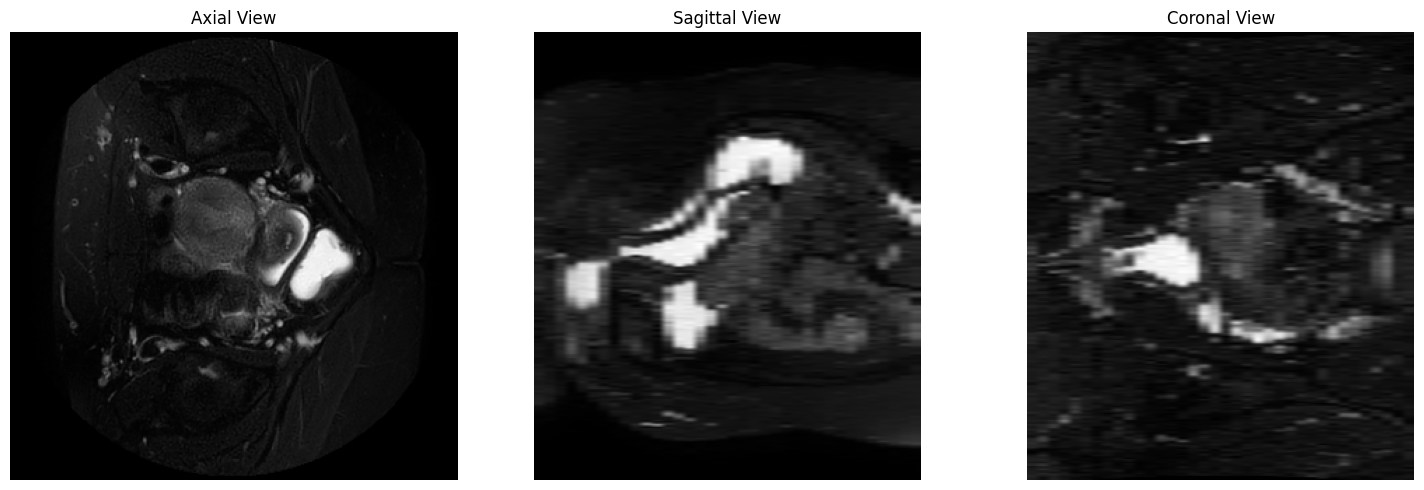

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

img = nib.load(str(t2fs_files[0]))
data = img.get_fdata()
sx, sy, sz = img.header.get_zooms()[:3]   # voxel size in mm along x,y,z

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (x–y plane): slice at z = mid
ax_slice = data[:, :, data.shape[2]//2]
axes[0].imshow(
    ax_slice, cmap='gray', origin='lower',
    extent=[0, ax_slice.shape[1]*sy, 0, ax_slice.shape[0]*sx]  # width=y*sy, height=x*sx
)
axes[0].set_title('Axial View'); axes[0].set_aspect('equal'); axes[0].axis('off')

# Sagittal (y–z plane): slice at x = mid
sag_slice = data[data.shape[0]//2, :, :]
axes[1].imshow(
    sag_slice, cmap='gray', origin='lower',
    extent=[0, sag_slice.shape[1]*sz, 0, sag_slice.shape[0]*sy]  # width=z*sz, height=y*sy
)
axes[1].set_title('Sagittal View'); axes[1].set_aspect('equal'); axes[1].axis('off')

# Coronal (x–z plane): slice at y = mid
cor_slice = data[:, data.shape[1]//2, :]
axes[2].imshow(
    cor_slice, cmap='gray', origin='lower',
    extent=[0, cor_slice.shape[1]*sz, 0, cor_slice.shape[0]*sx]  # width=z*sz, height=x*sx
)
axes[2].set_title('Coronal View'); axes[2].set_aspect('equal'); axes[2].axis('off')

plt.tight_layout(); plt.show()

## Step 11: Setup Complete

### Checklist:
- GPU environment configured
- Google Drive mounted
- Dependencies installed
- Dataset downloaded (8GB in Drive)
- Data splits created
- Project structure set up

### Storage Layout:
```
Google Drive/endo-seg/
├── data/raw/UT-EndoMRI/     # 8GB dataset (persistent)
├── data/splits/             # Train/val/test splits
├── experiments/
│   ├── checkpoints/         # Model weights (persistent)
│   ├── logs/               # Training logs
│   └── results/            # Predictions & metrics
└── code/                    # Your source code (backup)
```

### Next Steps:
1. **Continue to Phase 1:** Run data exploration
2. **Start Phase 2:** Implement and train baseline model
3. **Phase 3-4:** Implement Transformer + Uncertainty

### Colab Tips:
- Save checkpoints frequently (to Drive)
- Use smaller batch sizes (2-4) for T4 GPU
- Consider Colab Pro for longer runtimes
- Disconnect when not training to save compute quota

## Quick Commands Reference

In [ ]:
# Use this cell for quick re-setup in future sessions

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
PROJECT_ROOT = '/content/drive/MyDrive/endo-seg'
%cd /content/endo-uncertainty-seg

# Link data and experiments
!ln -sf {PROJECT_ROOT}/data /content/endo-seg/data
!ln -sf {PROJECT_ROOT}/experiments /content/endo-seg/experiments

import sys
sys.path.append('/content/endo-seg/src')

print(Quick setup complete!")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")